In [1]:
%load_ext autoreload
%autoreload 2

### imports and utilities

In [136]:
import numpy as np 
import pandas as pd

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 

from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline 
from sklearn.pipeline import FeatureUnion
from sklearn.datasets import fetch_20newsgroups
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import f1_score as calculate_f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold 
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout
K.clear_session()

### Utilities

In [65]:
## utilities
# from utils import clean_text

import string
from sklearn.base import TransformerMixin

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer


nltk.download('stopwords')
nltk.download('wordnet')


def clean_text(text: str, lemmatizer = lambda x: x) -> str:
    # removes upper cases
    text = text.lower().strip()
    
    # removes punctuation
    for char in string.punctuation:
        text = text.replace(char, " ")
    
    #lematize the words and join back into string text
    text = " ".join([lemmatizer(word) for word in word_tokenize(text)])
    return text


def data_isvalid(text, analyser, min_character_size, max_character_size):
    return min_character_size <= len(analyser(text)) <= max_character_size


def get_lemmatizer():
#     return lambda x: x
    return WordNetLemmatizer().lemmatize

def build_base_network(input_shape):
    model = Sequential()
    
    model.add(Dense(256, input_shape=input_shape))
    model.add(Dropout(0.2))
    
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.2))
    
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.2))
    
    model.add(Dense(128, activation="relu"))
    return model

    
def distance(emb1, emb2):
    return K.sum(K.square(emb1 - emb2), axis=-1)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Classifying Music Note sounds using Few Shot Deep Learning

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

### load dataset

In [5]:
# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.politics.mideast', 'alt.atheism', 'sci.space']

all_docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
categories = all_docs.target_names

In [6]:
print(all_docs.data[0])



I think that domestication will change behavior to a large degree.
Domesticated animals exhibit behaviors not found in the wild.  I
don't think that they can be viewed as good representatives of the
wild animal kingdom, since they have been bred for thousands of years
to produce certain behaviors, etc.


## Create Dataframe

In [7]:
featuresdf = pd.DataFrame(
    data={
        "text":all_docs.data, 
        "class_label":all_docs.target
    }
)
labels = np.unique(featuresdf.class_label)

featuresdf.head()

,text,class_label
0,\n\nI think that domestication will change beh...,0
1,"\nI don't like this comment about ""Typical"" th...",3
2,\n<apparently you're not a woman - my husband ...,1
3,"While not exactly a service incident, I had a ...",1
4,\n\nI think I can. Largely as a result of effo...,2


### Label Frequency

1    594
2    593
3    564
0    480
Name: class_label, dtype: int64



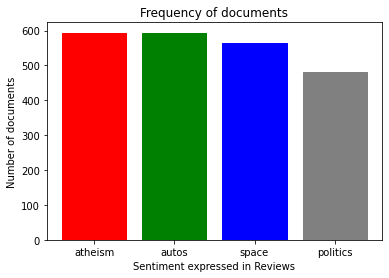

In [8]:
print(featuresdf["class_label"].value_counts())
print()

barlist = plt.bar(categories, featuresdf["class_label"].value_counts())

plt.title("Frequency of documents")
plt.xticks(categories, list(map(lambda x: x.split(".")[1], categories)))
plt.ylabel('Number of documents')
plt.xlabel('Sentiment expressed in Reviews')

barlist[0].set_color('red')
barlist[1].set_color('green')
barlist[2].set_color('blue')
barlist[3].set_color('grey')
plt.show()

# Select Valid Data

In [9]:
max_size_per_class = 500

# remove long text
min_chr_size = 128
max_chr_size = 256
indices = featuresdf["text"].apply(data_isvalid, args=(lambda x: clean_text(x, get_lemmatizer()), min_chr_size, max_chr_size))
featuresdf = featuresdf[indices]

# make classes balanced
class_indices = []

for index in range(4):
    class_indices.append(np.where((featuresdf["class_label"] == index))[0])
    
size_per_class = min(max_size_per_class, min(map(len, class_indices)))
indices = np.concatenate([class_ids[:size_per_class] for class_ids in class_indices])

featuresdf = featuresdf.iloc[indices]

featuresdf.head()

,text,class_label
19,"\n\n\tI agree, we spend too much energy on the...",0
50,\n\n Could you explain what any of the above p...,0
164,\nUh oh. This looks a bit too much like Bobby...,0
178,\n\nI'd have to say that I have a problem with...,0
197,"\nWell, that explains some things; I posted on...",0


In [10]:
print(featuresdf.iloc[0]["text"])



	I agree, we spend too much energy on the nonexistance of God.

--


       "Satan and the Angels do not have freewill.  
        They do what god tells them to do. "


3    66
2    66
1    66
0    66
Name: class_label, dtype: int64



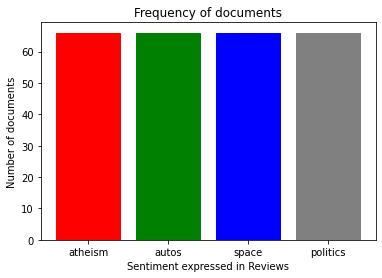

In [11]:
print(featuresdf["class_label"].value_counts())
print()

barlist = plt.bar(categories, featuresdf["class_label"].value_counts())

plt.title("Frequency of documents")
plt.xticks(categories, list(map(lambda x: x.split(".")[1], categories)))
plt.ylabel('Number of documents')
plt.xlabel('Sentiment expressed in Reviews')

barlist[0].set_color('red')
barlist[1].set_color('green')
barlist[2].set_color('blue')
barlist[3].set_color('grey')
plt.show()

### Clean Input

In [12]:
featuresdf["text"] = featuresdf["text"].apply(lambda x: clean_text(x, get_lemmatizer()))

### Extract features

In [55]:
min_df = 3
stop_words = "english"

vectorizer = TfidfVectorizer(stop_words=stop_words, min_df=min_df)

input_data = vectorizer.fit_transform(featuresdf["text"]).toarray()
output_labels = np.array(featuresdf["class_label"].tolist())

In [56]:
# featuresdf.feature = featuresdf.feature.apply(lambda xx: xx.reshape((4096, 2)))
print(input_data[0].shape)

(338,)


In [57]:
from itertools import combinations
from math import factorial

def number_of_combinations(n, r):
    return int(factorial(n) / (factorial(n - r) * factorial(r)))

def prepare_data_pair(X, y, labels):
    data = [[], [], []]
    data_labels = [[], [], []]
    
    for label in labels:
        indices = np.array(list(range(len(y))))
        similar_indices = indices[y == label]
        
        if len(similar_indices) < 2:
            continue
        
        train_half_size = number_of_combinations(len(similar_indices), 2)
        
        dissimilar_indices = indices[y != label]
        np.random.shuffle(dissimilar_indices)

        dissimilar_indices = dissimilar_indices[:train_half_size]
        np.random.shuffle(dissimilar_indices)

        counter = 0
        it = iter(dissimilar_indices)
        
        for i, j in combinations(similar_indices, 2):
            if counter >= len(dissimilar_indices):
                break
                
            counter += 1
            z = next(it)
            
            for index, value in enumerate([i, j, z]):
                data[index].append(X[value])
                data_labels[index].append(y[value])
            
        print(y[i], y[j], y[z])
    
    data = np.array(data)
    data_labels = np.array(data_labels)
    return data, data_labels

In [58]:
labels

array([0, 1, 2, 3], dtype=int64)

In [59]:
# split the dataset 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# split train and test data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=100)
for train_index, test_index in sss.split(input_data, output_labels):
    x_train, x_test = input_data[train_index], input_data[test_index]
    y_train, y_test = output_labels[train_index], output_labels[test_index]

# prepare data set pairs
x_train_pair, y_train_pair = prepare_data_pair(x_train, y_train, labels)

0 0 1
1 1 2
2 2 1
3 3 1


In [60]:
x_train.shape, y_train.shape

((198, 338), (198,))

In [61]:
x_test.shape, y_test.shape

((66, 338), (66,))

In [62]:
x_train_pair.shape, y_train_pair.shape

((3, 594, 338), (3, 594))

In [63]:
for i in range(3):
    print(y_train_pair[:, i])

[0 0 1]
[0 0 1]
[0 0 3]


### Compiling the model 

For compiling our model, we will use the same three parameters as the previous model: 

In [66]:
# from model import create_model as build_base_network

input_dim = x_train_pair.shape[2:]
base_network = build_base_network(input_dim)

audio_a = Input(shape=input_dim)
audio_p = Input(shape=input_dim)
audio_n = Input(shape=input_dim)

feat_vecs_a = base_network(audio_a)
feat_vecs_p = base_network(audio_p)
feat_vecs_n = base_network(audio_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
    def get_config(self):
        config = super(TripletLossLayer, self).get_config()
        config.update({"alpha": self.alpha})
        return config

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
difference = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([feat_vecs_a, feat_vecs_p, feat_vecs_n])

# initialize the network
model = Model(inputs=[audio_a, audio_p, audio_n], outputs=difference)

In [67]:
# Display model architecture summary 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 338)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 338)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 338)]        0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          251264      input_1[0][0]                    
                                                                 input_2[0][0]                

In [68]:
model.layers[3].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               86784     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

### Training 

Here we will train the model. As training a CNN can take a sigificant amount of time, we will start with a low number of epochs and a low batch size. If we can see from the output that the model is converging, we will increase both numbers.  

In [87]:
from tensorflow.keras.callbacks import ModelCheckpoint 
from time import time

# initialize training params
epochs = 32
batch_size = 16

# optimizer = Adam()
optimizer = RMSprop()
model.compile(loss=None, optimizer=optimizer)

start = time()
model.fit(
    [x_train_pair[0], x_train_pair[1], x_train_pair[2]], 
    None, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_split=0.25,
    verbose=1
)

duration = (time() - start)/60
print("Training completed in time: ", duration, "min")

Epoch 1/32
28/28 [==============================] - 2s 26ms/step - loss: 0.0074 - val_loss: 3.8852
Epoch 2/32
28/28 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 3.8852
Epoch 3/32
28/28 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 3.8852
Epoch 4/32
28/28 [==============================] - 0s 7ms/step - loss: 0.0180 - val_loss: 4.3097
Epoch 5/32
28/28 [==============================] - 0s 7ms/step - loss: 0.0138 - val_loss: 4.7664
Epoch 6/32
28/28 [==============================] - 0s 6ms/step - loss: 0.0488 - val_loss: 3.3681
Epoch 7/32
28/28 [==============================] - 0s 7ms/step - loss: 0.0494 - val_loss: 3.0426
Epoch 8/32
28/28 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 3.0426
Epoch 9/32
28/28 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - val_loss: 3.0426
Epoch 10/32
28/28 [==============================] - 0s 7ms/step - loss: 0.0228 - val_loss: 2.7479
Ep

#### Evaluation

In [88]:
from sklearn.decomposition import PCA

def plot_label_clusters(model, data, labels, pca1=None, pca2=None):
    # display a 2D plot of the digit classes in the latent space
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Embeddings')
    fig.set_figwidth(15)
    fig.set_figheight(5)
    
    if not pca1:
        pca1 = PCA(n_components=2)
        pca1.fit(data)
        
    z = pca1.transform(data)
    ax1.scatter(z[:, 0], z[:, 1], c=labels)
    ax1.set_xlabel("y")
    ax1.set_ylabel("x")
    
    if not pca2:
        pca2 = PCA(n_components=2)
        pca2.fit(model.predict(data))
        
    z = pca2.transform(model.predict(data))
    ax2.scatter(z[:, 0], z[:, 1], c=labels)
    ax2.set_xlabel("x")

    plt.show()
    return pca1, pca2

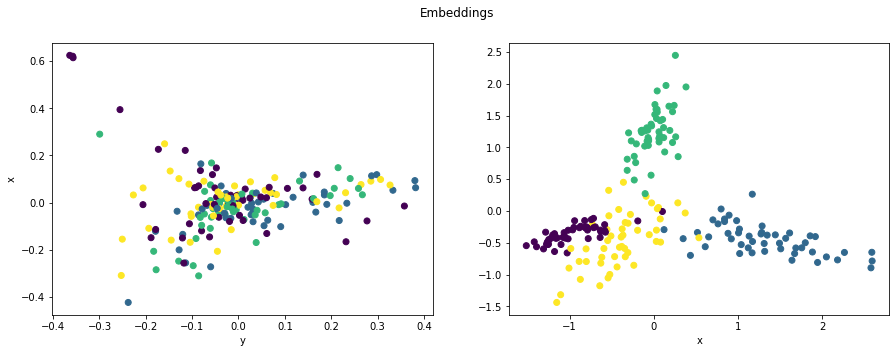

In [135]:
pca1, pca2 = plot_label_clusters(model.layers[3], x_train, y_train)

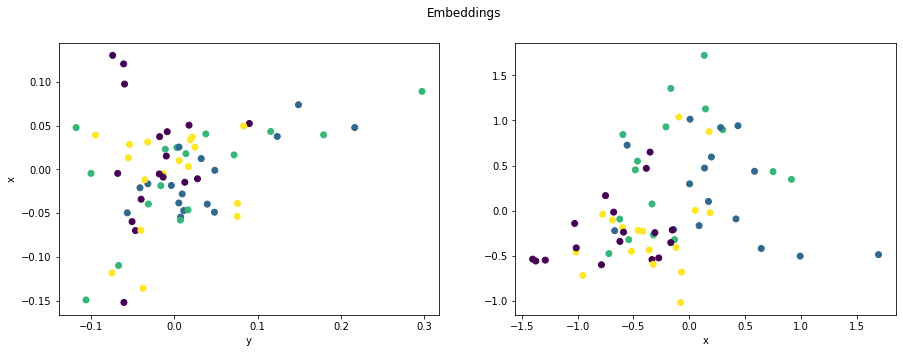

(PCA(n_components=2), PCA(n_components=2))

In [90]:
plot_label_clusters(model.layers[3], x_test, y_test, pca1, pca2)

### Best freq treshold

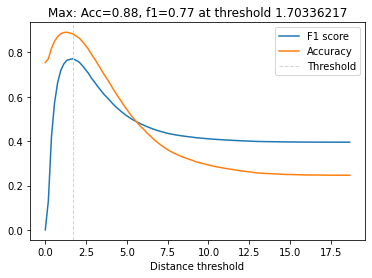

In [162]:
from sklearn.metrics import f1_score, accuracy_score

def get_eval_params(data_input, data_labels):
    pairs = []
    distances = [] # squared L2 distance between pairs
    identical = [] # 1 if same identity, 0 otherwise

    num = len(data_input)
    embedded = model.layers[3].predict(data_input)

    for i in range(num):
        for j in range(num):
            if i == j:
                continue
            pairs.append([embedded[i], embedded[j]])
            distances.append(distance(embedded[i], embedded[j]))
            identical.append(1 if data_labels[i] == data_labels[j] else 0)
            
    pairs = np.array(pairs)
    distances = np.array(distances)
    identical = np.array(identical)
    
    return pairs, distances, identical, embedded

train_pairs, train_distances, train_identical, train_embedded = get_eval_params(x_train, y_train)
test_pairs, test_distances, test_identical, test_embedded = get_eval_params(x_test, y_test)

min_threshold = min(train_distances)
max_threshold = max(train_distances)
threshold_step = (max_threshold - min_threshold)/100
thresholds = np.arange(min_threshold, max_threshold, threshold_step)

f1_scores = [f1_score(train_identical, train_distances < t) for t in thresholds]
acc_scores = [accuracy_score(train_identical, train_distances < t) for t in thresholds]

# max f1
opt_idx = np.argmax(f1_scores)
opt_f1 = np.max(f1_scores)

# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]

# Accuracy at maximal F1 score
opt_acc = accuracy_score(train_identical, train_distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Max: Acc={opt_acc:.2f}, f1={opt_f1:.2f} at threshold {opt_tau:.8f}');
plt.xlabel('Distance threshold')
plt.legend();

In [163]:
train_distances.shape, train_pairs.shape, train_identical.shape

((39006,), (39006, 2, 128), (39006,))

In [93]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

prediction = test_distances < opt_tau

print("accuracy =", accuracy_score(test_identical, prediction))

print("\nclassification_report")
print("========================")
print(classification_report(test_identical, prediction))

print("\nconfusion matrix")
print("========================")
print(confusion_matrix(test_identical, prediction))

accuracy = 0.5431588613406795

classification_report
              precision    recall  f1-score   support

           0       0.81      0.51      0.62      3266
           1       0.31      0.65      0.42      1090

    accuracy                           0.54      4356
   macro avg       0.56      0.58      0.52      4356
weighted avg       0.69      0.54      0.57      4356


confusion matrix
[[1656 1610]
 [ 380  710]]


### Bayes Model

In [152]:
def get_model():
    return LogisticRegression(random_state=0)
#     return ComplementNB()
#     return GaussianNB()
#     return KMeans(n_clusters=4, random_state=0)

In [153]:
clf = get_model()
clf.fit(x_train, y_train)

print(f"train accuracy = {clf.score(x_train, y_train):.2f}")

train accuracy = 0.97


In [154]:
print(f"train accuracy = {clf.score(x_test, y_test):.2f}")

train accuracy = 0.61


In [155]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(x_test)
confusion_matrix(y_test, y_pred)

array([[10,  0,  4,  3],
       [ 1,  9,  6,  0],
       [ 3,  1,  9,  3],
       [ 3,  0,  2, 12]], dtype=int64)

In [156]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.59      0.59        17
           1       0.90      0.56      0.69        16
           2       0.43      0.56      0.49        16
           3       0.67      0.71      0.69        17

    accuracy                           0.61        66
   macro avg       0.65      0.60      0.61        66
weighted avg       0.65      0.61      0.61        66



### Bayes Model with embedding

In [157]:
x_emb_train = model.layers[3].predict(x_train)
x_emb_test = model.layers[3].predict(x_test)

pca = PCA(n_components=2)
pca.fit(x_emb_train)

x_emb_train = pca.transform(x_emb_train)
x_emb_test = pca.transform(x_emb_test)

In [158]:
emb_clf = get_model()
emb_clf.fit(x_emb_train, y_train)

print(f"train accuracy = {emb_clf.score(x_emb_train, y_train):.2f}")

train accuracy = 0.91


In [159]:
print(f"test accuracy = {emb_clf.score(x_emb_test, y_test):.2f}")

test accuracy = 0.44


In [160]:
from sklearn.metrics import confusion_matrix

y_pred = emb_clf.predict(x_emb_test)
confusion_matrix(y_test, y_pred)

array([[ 7,  0,  2,  8],
       [ 1,  5,  7,  3],
       [ 2,  2,  7,  5],
       [ 5,  0,  2, 10]], dtype=int64)

In [161]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.41      0.44        17
           1       0.71      0.31      0.43        16
           2       0.39      0.44      0.41        16
           3       0.38      0.59      0.47        17

    accuracy                           0.44        66
   macro avg       0.49      0.44      0.44        66
weighted avg       0.49      0.44      0.44        66



### Testing (new data) Evaluation

In [98]:
x_test_sample = []
y_test_sample = []

sample_dirs = ["EH", "D", "A", "B", "G", "EL"]
# sample_dirs = ["A"]

for label in tqdm(sample_dirs):
    print(label, end=", ")
    labeldir= os.path.join("data", "old_guitar_sample", label)

    for filename in (os.listdir(labeldir)):
        anchor_filepath = os.path.join("data", "old_guitar_sample", label, filename)
        
        anchor_file_vector = extract_features(anchor_filepath)
        anchor_file_vector = np.expand_dims(anchor_file_vector, axis=-1)
        x_test_sample.append(anchor_file_vector)
        y_test_sample.append("1"+label)

print()
x_test_sample = np.array(x_test_sample)
y_test_sample = np.array(y_test_sample)

print(x_test_sample.shape)

EH, D, A, B, G, EL, 

(58, 40, 256, 1)


In [99]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise
prediction = []

num = len(x_test_sample)
print(x_test_sample.shape)
embedded = model.layers[3].predict(x_test_sample)

for i in range(num):
    for j in range(num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if y_test_sample[i] == y_test_sample[j] else 0)
        prediction.append(1 if distances[-1] < opt_tau else 0)
        
distances = np.array(distances)
identical = np.array(identical)
prediction = np.array(prediction)

print("accuracy =", accuracy_score(identical, prediction))

print("\nclassification_report")
print("========================")
print(classification_report(identical, prediction))

print("\nconfusion matrix")
print("========================")
print(confusion_matrix(identical, prediction))

(58, 40, 256, 1)
accuracy = 0.8632580261593341

classification_report
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      2802
           1       0.55      0.94      0.70       562

    accuracy                           0.86      3364
   macro avg       0.77      0.89      0.80      3364
weighted avg       0.91      0.86      0.88      3364


confusion matrix
[[2378  424]
 [  36  526]]


In [100]:
if using_distance:
    x_test_sample, y_test_sample = distances.reshape(-1, 1), identical

else:
    x_test_sample, y_test_sample = embedded, le.transform(y_test_sample)

In [101]:
print(f"test accuracy = {clf.score(x_test_sample, y_test_sample):.2f}")

test accuracy = 0.86


In [102]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(x_test_sample)
confusion_matrix(y_test_sample, y_pred)

array([[2360,  442],
       [  36,  526]], dtype=int64)

In [103]:
from sklearn.metrics import classification_report

print(classification_report(y_test_sample, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.84      0.91      2802
           1       0.54      0.94      0.69       562

    accuracy                           0.86      3364
   macro avg       0.76      0.89      0.80      3364
weighted avg       0.91      0.86      0.87      3364



### Testing (sample) Evaluation

In [104]:
x_test_sample = []
y_test_sample = []

sample_dirs = ["1EH", "1D", "1A", "1B", "1G", "1EL"]

sample_label = "1A"
sample_filepath = os.path.join("data", "sampleA.wav")
sample_vector = extract_features(sample_filepath)
sample_vector = np.expand_dims(np.expand_dims(sample_vector, axis=-1), axis=0)
sample_embedded = model.layers[3].predict(sample_vector)

for label in tqdm(sample_dirs):
    print(label, end=", ")
    labeldir= os.path.join(DATA_DIR, label)

    for filename in (os.listdir(labeldir)):
        anchor_filepath = os.path.join(DATA_DIR, label, filename)
        
        anchor_file_vector = extract_features(anchor_filepath)
        anchor_file_vector = np.expand_dims(anchor_file_vector, axis=-1)
        x_test_sample.append(anchor_file_vector)
        y_test_sample.append(label)

print()
x_test_sample = np.array(x_test_sample)
y_test_sample = np.array(y_test_sample)

print(x_test_sample.shape)

1EH, 1D, 1A, 1B, 1G, 1EL, 

(118, 40, 256, 1)


In [105]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

identical = []
distances = [] # squared L2 distance between pairs
prediction = []

num = len(x_test_sample)
embedded = model.layers[3].predict(x_test_sample)

for i in range(num):
    identical.append(1 if sample_label == y_test_sample[i] else 0)
    distances.append(distance(embedded[i], sample_embedded))
    prediction.append(1 if distances[-1] < opt_tau else 0)

identical = np.array(identical)
distances = np.array(distances)
prediction = np.array(prediction)

print("accuracy =", accuracy_score(identical, prediction))

print("\nclassification_report")
print("========================")
print(classification_report(identical, prediction))

print("\nconfusion matrix")
print("========================")
print(confusion_matrix(identical, prediction))

accuracy = 0.711864406779661

classification_report
              precision    recall  f1-score   support

           0       0.81      0.86      0.83        98
           1       0.00      0.00      0.00        20

    accuracy                           0.71       118
   macro avg       0.40      0.43      0.42       118
weighted avg       0.67      0.71      0.69       118


confusion matrix
[[84 14]
 [20  0]]


In [106]:
if using_distance:
    x_test_sample, y_test_sample = distances.reshape(-1, 1), identical

else:
    x_test_sample, y_test_sample = sample_embedded, le.transform([sample_label])

In [107]:
print(f"test accuracy = {clf.score(x_test_sample, y_test_sample):.2f}")

test accuracy = 0.70


In [108]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(x_test_sample)
confusion_matrix(y_test_sample, y_pred)

array([[83, 15],
       [20,  0]], dtype=int64)

In [109]:
from sklearn.metrics import classification_report

print(classification_report(y_test_sample, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83        98
           1       0.00      0.00      0.00        20

    accuracy                           0.70       118
   macro avg       0.40      0.42      0.41       118
weighted avg       0.67      0.70      0.69       118

